In [5]:
import numpy as np
import polyflexmd.data_analysis.theory.rouse as rouse
import polyflexmd.data_analysis.plot.utils as plot_utils
import polyflexmd.data_analysis.plot.msd as msd_plot
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

sns.set_style("darkgrid")

sns.set_style("darkgrid")

params = {
    'axes.labelsize': 10,
    'figure.dpi': 300,
    "figure.figsize": plot_utils.get_figure_size(width=1, n_rows=1)
}

plt.rcParams.update(params)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
N = 63
b = .97
zeta = 1.0
L_contour = N * b
l_K = 2 * b

In [74]:
def get_rouse_msdlm_df(ts):
    tau_R = 1 / (3 * np.pi ** 2) * N ** 2 * b ** 2 * zeta
    R = N * b ** 2
    msdlm = rouse.rouse_msdlm(ts, R_sq=R, tau_R=tau_R, N=N)
    df_theor = pd.DataFrame({
        "t/LJ": ts,
        "dr_N^2": msdlm
    })
    return df_theor


ts = np.logspace(-5, 6, base=10, num=50000)
df_msdlm_rouse = get_rouse_msdlm_df(ts)
df_msdlm_rouse

,t/LJ,dr_N^2
0,0.000010,0.000060
1,0.000010,0.000060
2,0.000010,0.000060
3,0.000010,0.000060
4,0.000010,0.000060
...,...,...
49995,997975.736183,95064.874920
49996,998481.417659,95113.035061
49997,998987.355367,95161.219605
49998,999493.549437,95209.428564


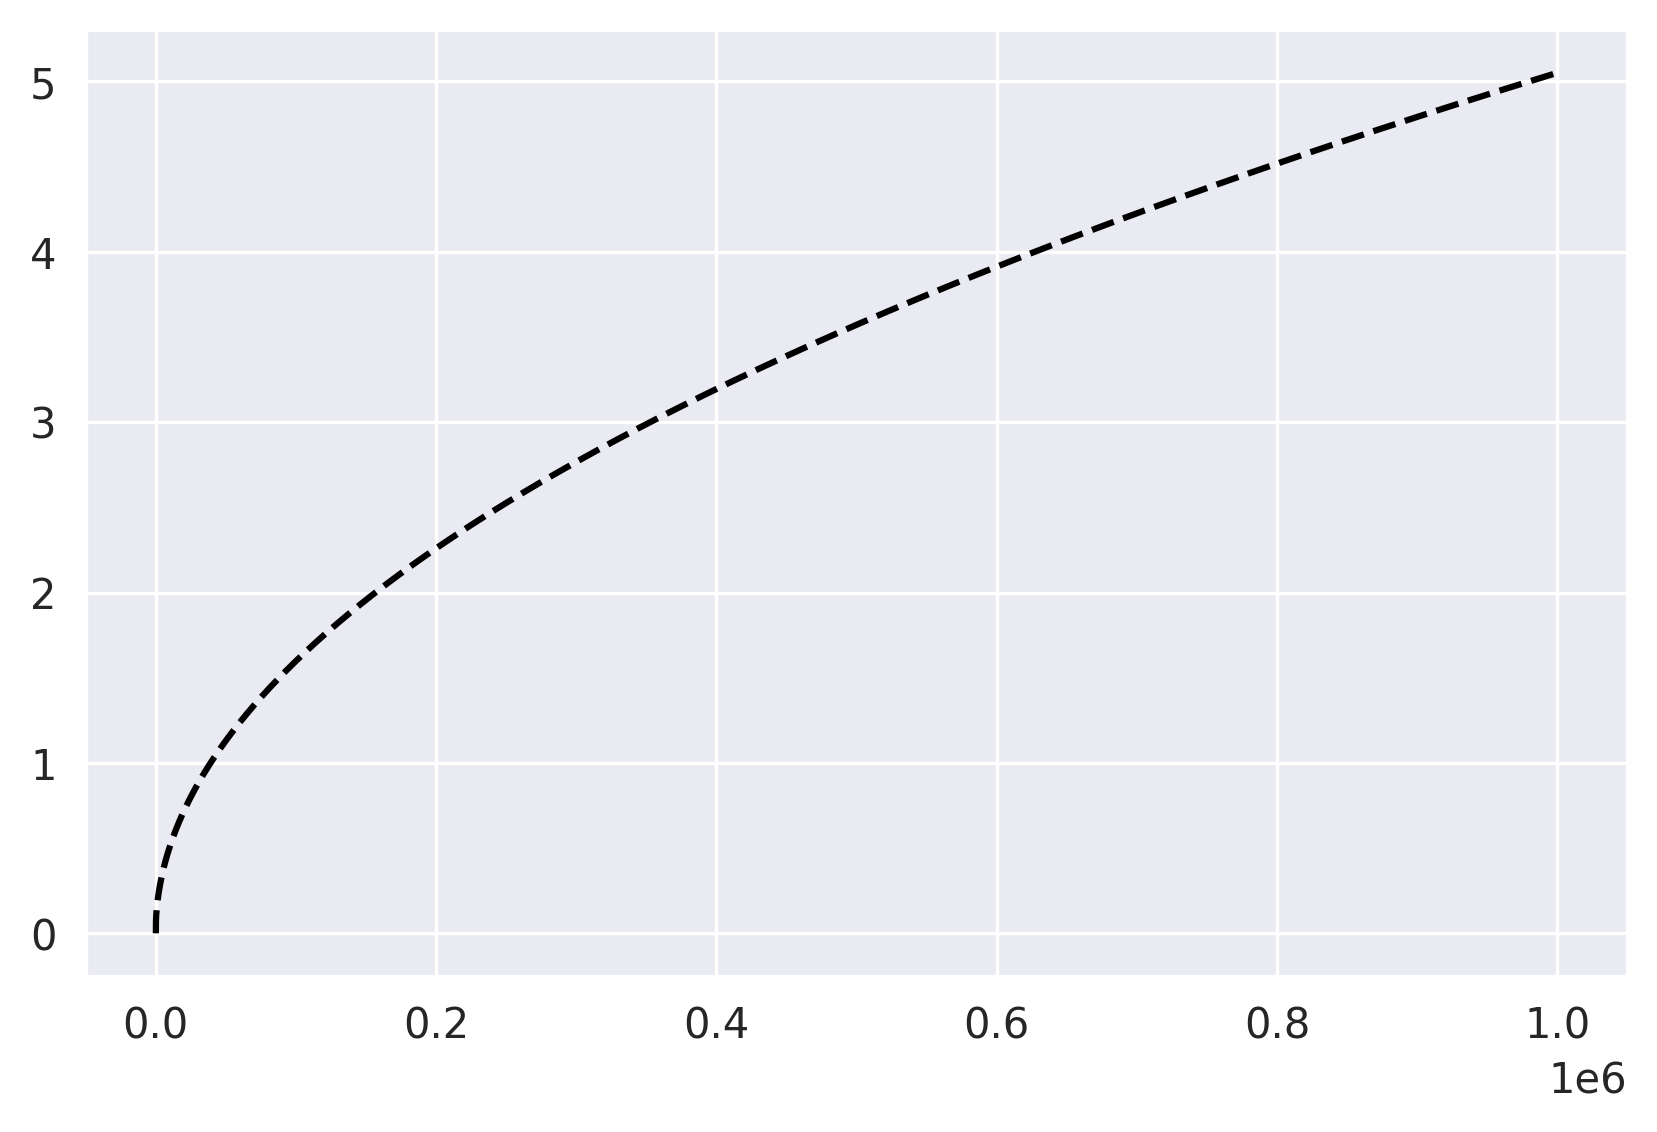

In [75]:
fig, ax = plt.subplots()

ax.plot(
    df_msdlm_rouse["t/LJ"],
    np.sqrt(df_msdlm_rouse["dr_N^2"]) / L_contour,
    label="Rouse",
    linestyle="--",
    color="black"
)

[None, None]

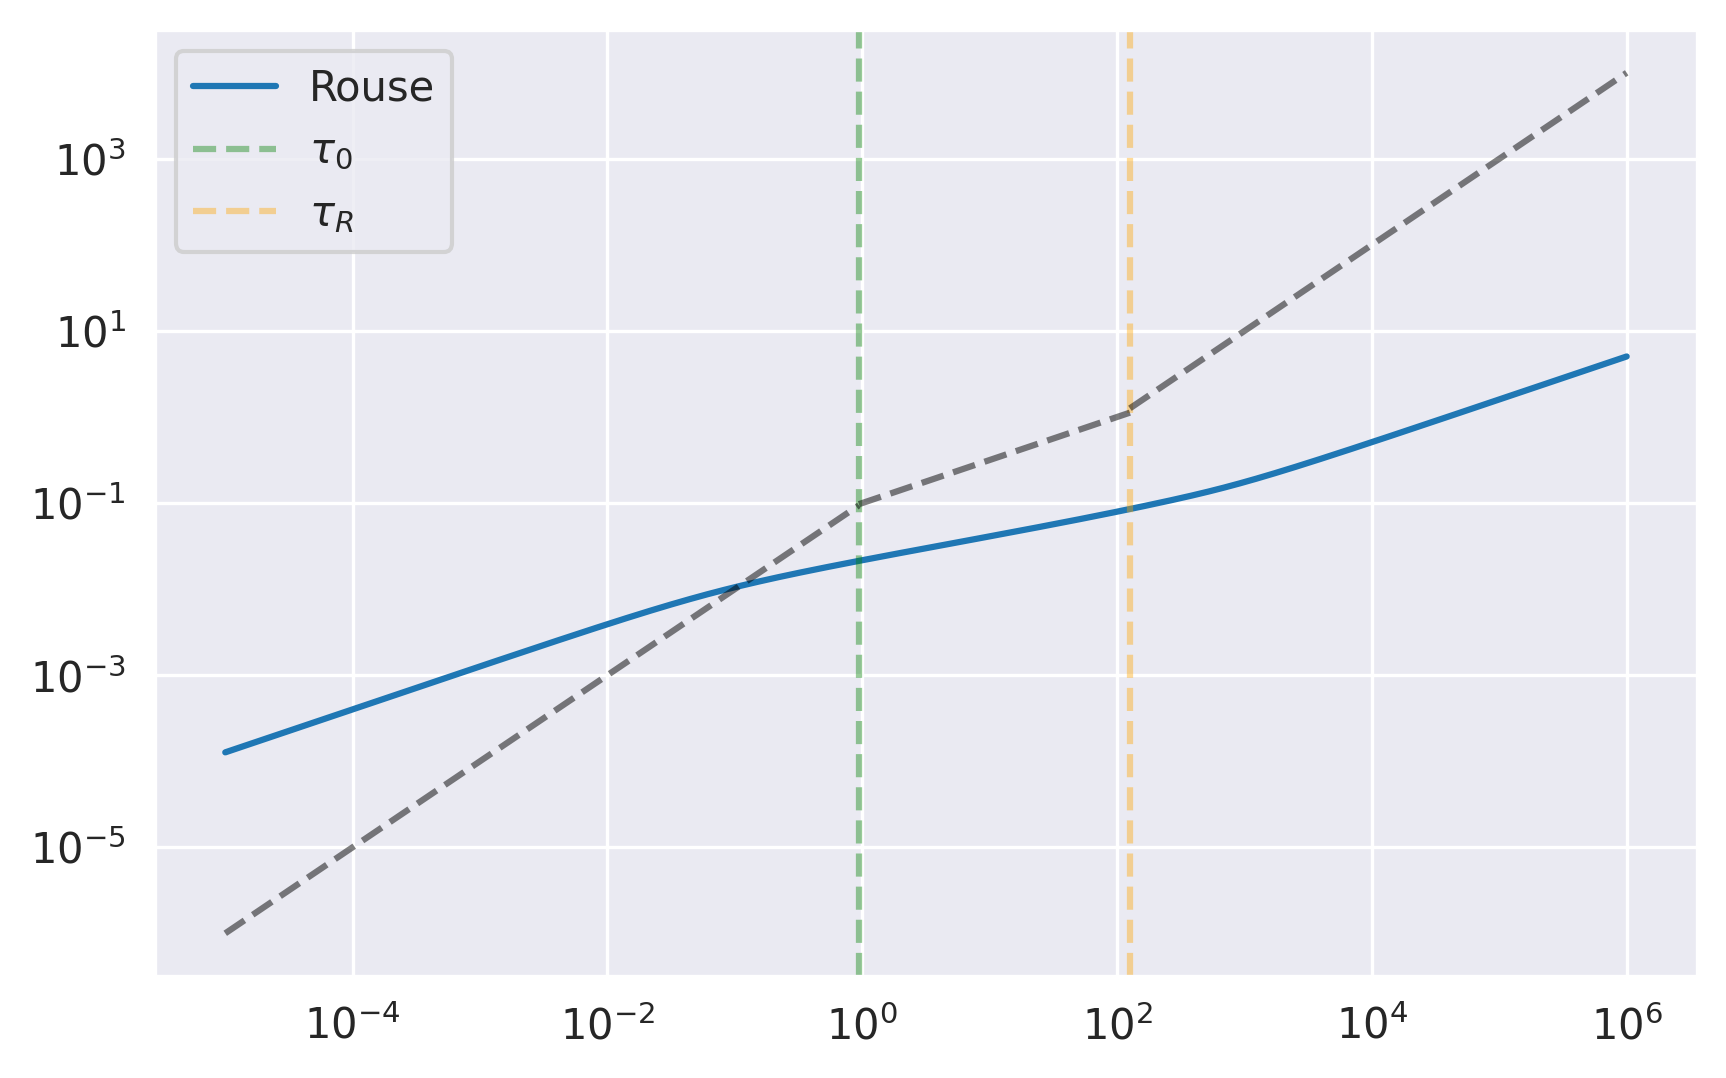

In [76]:
ax: plt.Axes

fig, ax = plt.subplots()

ax.plot(
    df_msdlm_rouse["t/LJ"],
    np.sqrt(df_msdlm_rouse["dr_N^2"]) / L_contour,
    label="Rouse",
)

tau_0 = b ** 2 * zeta
tau_R = tau_0 * N ** 2 / (3 * np.pi ** 2)

ax.axvline(x=tau_0, label="$\\tau_0$", linestyle="--", color="green", alpha=0.4)
ax.axvline(x=tau_R, label="$\\tau_R$", linestyle="--", color="orange", alpha=0.4)

df_1 = df_msdlm_rouse.loc[df_msdlm_rouse["t/LJ"] < tau_0]
df_2 = df_msdlm_rouse.loc[(df_msdlm_rouse["t/LJ"] > tau_0) & (df_msdlm_rouse["t/LJ"] < tau_R)]
df_3 = df_msdlm_rouse.loc[df_msdlm_rouse["t/LJ"] > tau_R]

ax.plot(df_1["t/LJ"], 0.1 * df_1["t/LJ"], linestyle="--", color="black", alpha=0.5)
ax.plot(df_2["t/LJ"], 0.1 * df_2["t/LJ"] ** 0.5, linestyle="--", color="black", alpha=0.5)
ax.plot(df_3["t/LJ"], 0.01 * df_3["t/LJ"], linestyle="--", color="black", alpha=0.5)

ax.legend()
ax.set(xscale="log", yscale="log")

In [72]:
import matplotlib.transforms as transforms

from scipy.optimize import curve_fit
import multiprocessing.pool
import tqdm


def linregbin(df):
    col = "dr_N^2"
    if len(df) < 3:
        return pd.Series([np.NAN, np.NAN, np.NAN, np.NAN, np.NAN, np.NAN],
                         index=["t/LJ", "alpha", "delta alpha", "delta t", "interval", "count"])
    f = lambda x, k: k * x
    xs = np.log10(df["t/LJ"])
    ys = np.log10(df[col])
    xs = xs - xs.min()
    ys = ys - ys.min()
    if f"delta {col}" in df.columns:
        dr = df[col]
        sigma_dr = df[f"delta {col}"] / 3
        dys = np.abs(1 / (dr * np.log(10)) * sigma_dr)
        popt, pcov = curve_fit(f, xs, ys, p0=(0.0), sigma=dys, absolute_sigma=True)
    else:
        popt, pcov = curve_fit(f, xs, ys, p0=(0.0))
    delta_alpha = np.sqrt(np.diag(pcov)[0]) * 3
    t_min = df["t/LJ"].min()
    t_max = df["t/LJ"].max()
    delta_t = (t_max - t_min) / 2
    t = t_min + delta_t
    return pd.Series(
        [t, popt[0], delta_alpha, delta_t, (t_min, t_max), df.shape[0]],
        index=["t/LJ", "alpha", "delta alpha", "delta t", "interval", "count"]
    )


log_window_size = 0.1
df = df_msdlm_rouse
# Estimate alpha
t_like_log_index = pd.TimedeltaIndex(
    np.log10(df["t/LJ"]),
    unit='seconds',
    name="log10(t/LJ)"
)
df = df.set_index(t_like_log_index)
rolling_window_iter = df.rolling(window=pd.Timedelta(log_window_size, unit="s"), min_periods=3)
with multiprocessing.pool.Pool(processes=32) as p:
    results = tqdm.tqdm(
        p.imap(linregbin, rolling_window_iter, chunksize=20),
        total=df.shape[0],
        leave=True,
        position=0,
    )
    df_alpha = pd.DataFrame(results)
    display(df_alpha)


100%|██████████| 50000/50000 [00:13<00:00, 3718.36it/s]


,t/LJ,alpha,delta alpha,delta t,interval,count
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,0.000010,0.722647,2.780981e-05,5.068356e-09,"(1e-05, 1.0010136711217143e-05)",3.0
3,0.000010,0.722621,3.534612e-05,7.604460e-09,"(1e-05, 1.0015208919409262e-05)",4.0
4,0.000010,0.722596,4.079852e-05,1.014185e-08,"(1e-05, 1.0020283697725716e-05)",5.0
...,...,...,...,...,...,...
49995,895455.730339,0.999760,7.418460e-07,1.025200e+05,"(792935.7244951567, 997975.7361829666)",455.0
49996,895909.464191,0.999760,7.414705e-07,1.025720e+05,"(793337.5107238205, 998481.4176587182)",455.0
49997,896363.427954,0.999760,7.410952e-07,1.026239e+05,"(793739.500540453, 998987.3553669068)",455.0
49998,896817.621743,0.999760,7.407200e-07,1.026759e+05,"(794141.6940482139, 999493.5494373672)",455.0


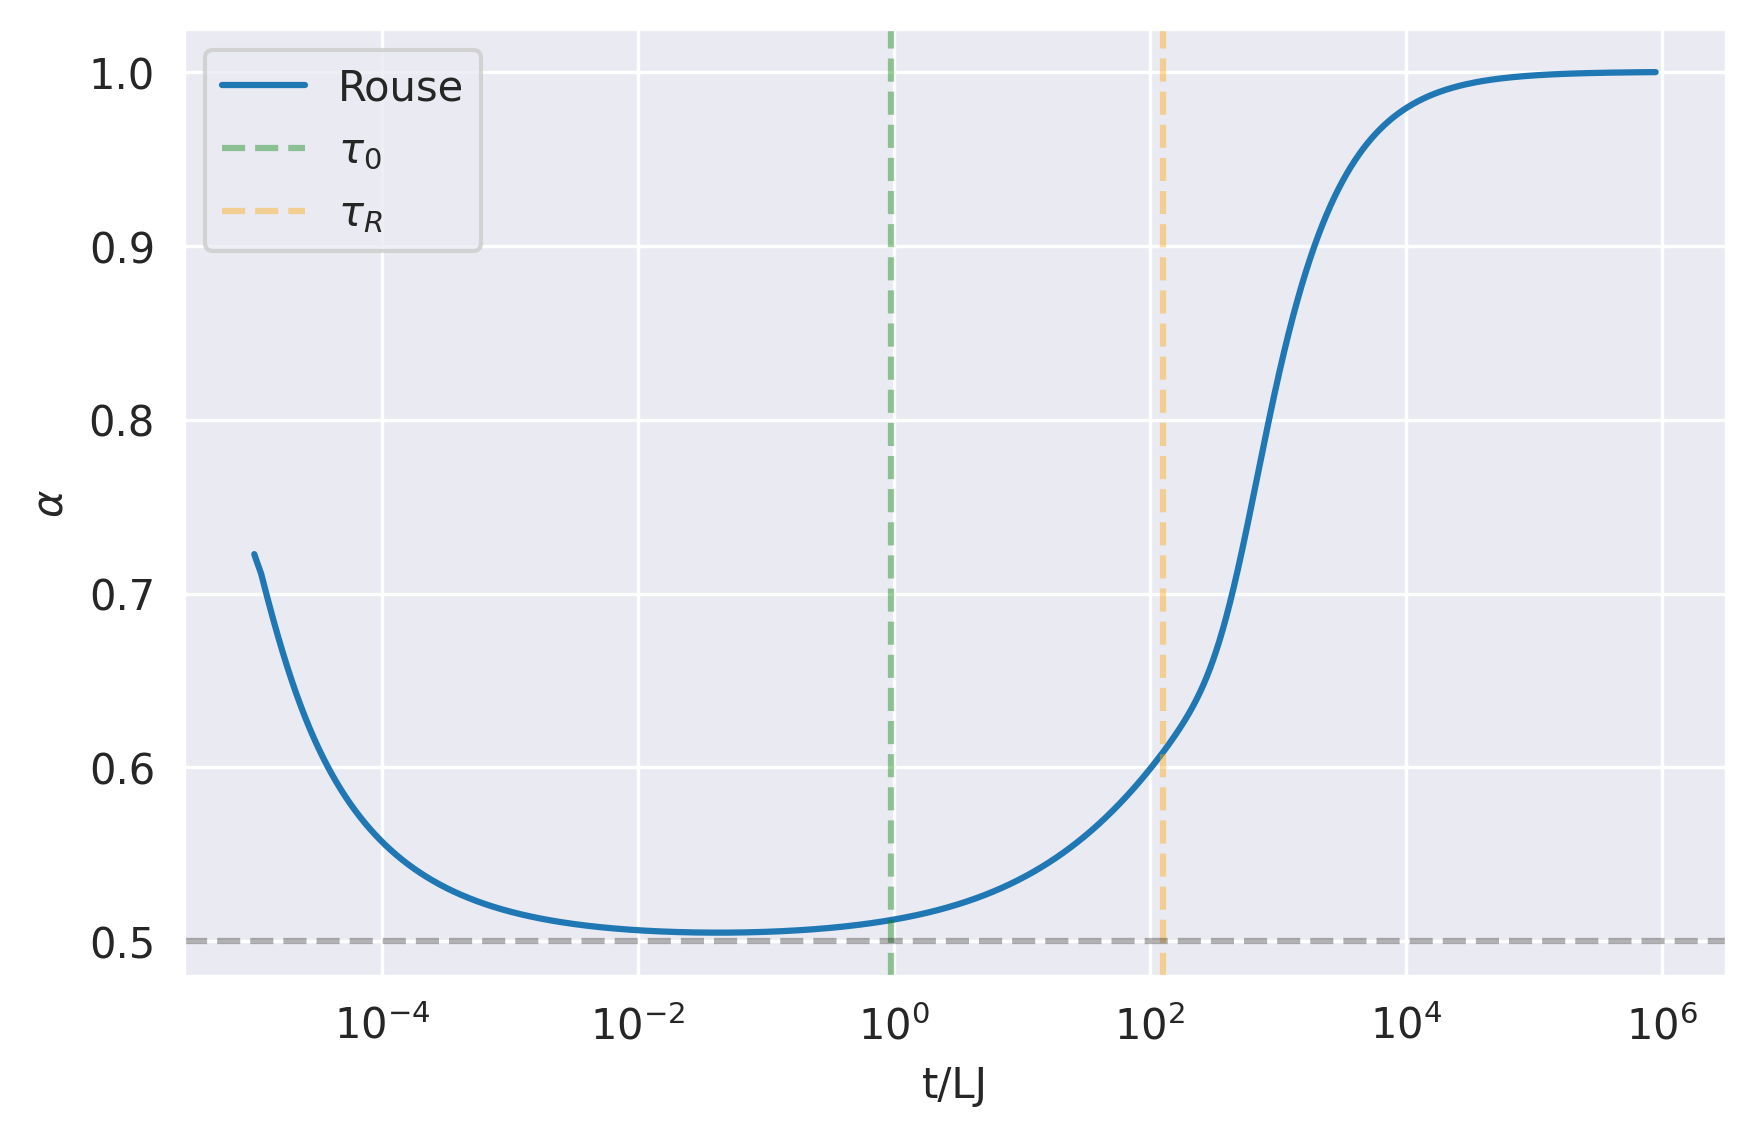

In [73]:
fig, ax = plt.subplots()

ax.plot(df_alpha["t/LJ"], df_alpha["alpha"], label="Rouse")

ax.axvline(x=tau_0, label="$\\tau_0$", linestyle="--", color="green", alpha=0.4)
ax.axvline(x=tau_R, label="$\\tau_R$", linestyle="--", color="orange", alpha=0.4)

ax.set(xscale="log", xlabel="t/LJ", ylabel="$\\alpha$")

ax.axhline(y=1/2, linestyle="--", color="black", alpha=0.3)

ax.legend()